# `Semana da Estatística`: Attribution

This notebook is intended to serve as a guide to the use of **Attribution** techniques/tools in the context of Machine Learning.

We will focus in the so called *"Pure-predictive models"* such as Random Forests and Gradient Boosting Machines. Tree based algorithms hace feature importance attribution methods and we will compare two of them:
* **Mean Decrease Impurity**
* **Permutation Importance**

To end the notebook we will illustrate the use of SHAP values to explain binary classification models (XGBoost).

# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


# Classification metrics
from sklearn.metrics import roc_auc_score
# sklearn standard utils
from sklearn.model_selection import train_test_split
# Datasets we will use in this tutorial
from sklearn.datasets import load_breast_cancer

# Attribution in *pure-predictive* models

## Decision Trees

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Load data and split in train/test

In [3]:
breast_cancer_data = load_breast_cancer(return_X_y=False, as_frame = True)
X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data.data, 
                                                    breast_cancer_data.target,
                                                    stratify = breast_cancer_data.target)

Fit a single Decision Tree classifier on the train data

In [4]:
print(breast_cancer_data['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [5]:
breast_cancer_data.target.sum()

357

In [6]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier()

Let's visualize the Tree's structure:

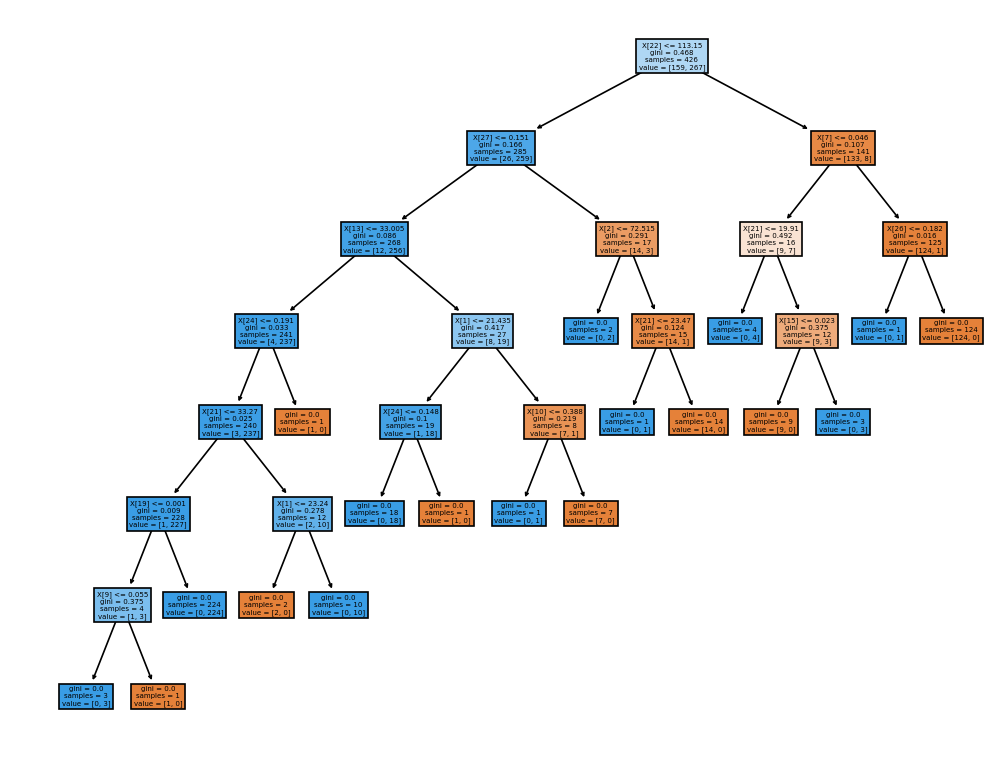

In [7]:
f, ax = plt.subplots(dpi =120, figsize = (10,8))
plot_tree(clf_dt,ax = ax, filled = True)
plt.show()

## Random Forests

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [9]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

Let's create a dataframe with the feature importances (MDI)

In [10]:
rf_feature_importances = pd.DataFrame({'feature_name': breast_cancer_data.feature_names, 
                                       'feature_importance': clf_rf.feature_importances_})\
                                    .sort_values('feature_importance', ascending = False)


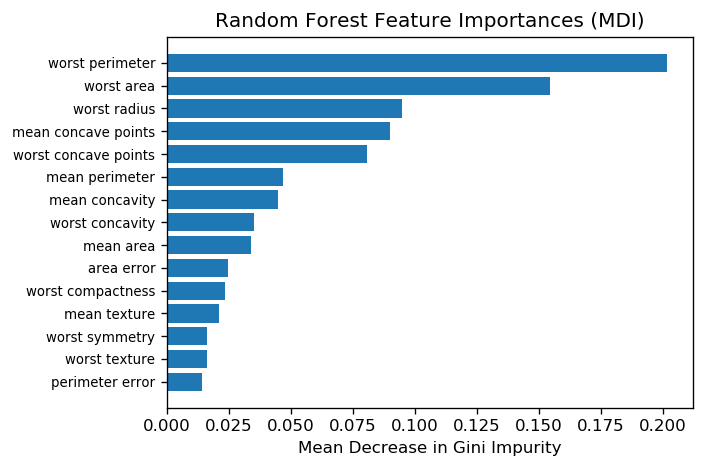

In [11]:
n_features = 15
y_ticks = np.arange(0, len(breast_cancer_data.feature_names[n_features-1::-1]))
f, ax = plt.subplots(dpi = 120)
ax.barh(y_ticks, rf_feature_importances.feature_importance[n_features-1::-1])
ax.set_yticks(y_ticks)
ax.set_yticklabels(rf_feature_importances.feature_name[n_features-1::-1], fontsize = 8)
ax.set_title("Random Forest Feature Importances (MDI)")
ax.set_xlabel("Mean Decrease in Gini Impurity")
f.tight_layout()
plt.show()

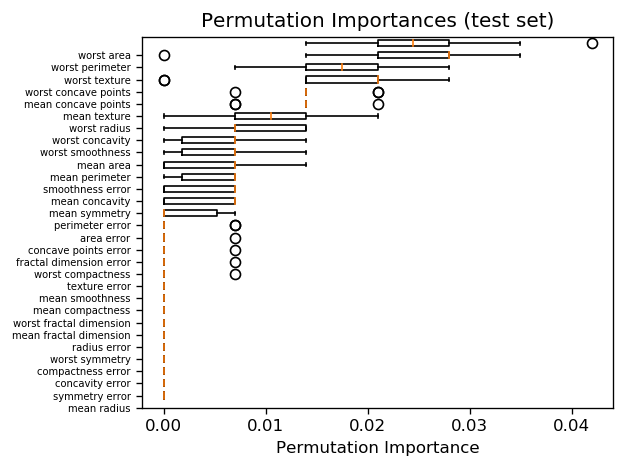

In [12]:
result = permutation_importance(clf_rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
y_ticks = np.arange(0, len(X_test.columns[sorted_idx]))
fig, ax = plt.subplots(dpi = 120)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels = X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
ax.set_xlabel('Permutation Importance')
fig.tight_layout()
ax.set_yticks(y_ticks)
ax.set_yticklabels(X_test.columns[sorted_idx], fontsize =6)
plt.show()

## Experiment: Removing most important features

In [13]:
y_proba = clf_rf.predict_proba(X_test)
roc_auc_score(y_test.values, y_proba[:,1:].ravel())

0.9938155136268344

In [14]:
important_features = list(rf_feature_importances.feature_name.values)
feature_names = breast_cancer_data.feature_names
results = {feature_name: {} for feature_name in important_features[:-5]}
features_train = important_features.copy()
for i, feature_name in enumerate(important_features[:-5]):
    features_train.remove(feature_name)
    model = RandomForestClassifier()
    model.fit(X_train[features_train], y_train)
    y_proba = model.predict_proba(X_test[features_train])
    roc_auc = roc_auc_score(y_test.values, y_proba[:,1:].ravel())
    results[feature_name] = roc_auc

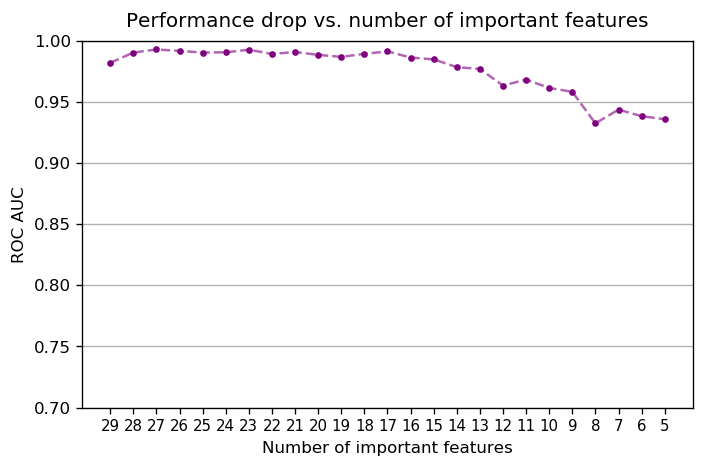

In [15]:
f, ax = plt.subplots(dpi = 120)
x = np.arange(0,len(results.values()))
ax.scatter(x, list(results.values()), 
           marker = '.', c = 'purple',)
ax.plot(x, list(results.values()), 
        c = 'purple', alpha = 0.6, 
        linestyle = '--', linewidth = 1.5)
ax.axhline(1, alpha = 0.7, c = 'black', linewidth = 1)
ax.set_ylabel('ROC AUC')
ax.set_ylim((0.7,1))
ax.set_xticks(x)
ax.set_xticklabels([c+5 for c in x[::-1]], fontsize = 9)
ax.set_xlabel('Number of important features')
ax.set_title('Performance drop vs. number of important features', y = 1.01)
ax.grid(True, axis = 'y')
f.tight_layout()

# SHAP values

In [16]:
from xgboost import XGBClassifier
import shap

In [17]:
shap.initjs()

In [18]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_proba = xgb.predict_proba(X_test)
roc_auc_score(y_test, y_proba[:,1:].ravel())

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:56:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9882599580712789

In [19]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
df_shap = pd.DataFrame(data = shap_values, columns = X_test.columns)
df_shap.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.047878,-0.586084,0.042471,0.122613,-0.096095,0.006247,0.030998,0.994006,-0.138099,0.308438,...,0.348448,0.375381,0.712340,0.318941,0.520331,0.011077,0.814246,0.778042,0.660947,0.019235
1,0.013697,-1.137736,-0.042417,0.410205,0.265226,0.011905,0.030998,1.019589,-0.138099,0.342075,...,0.382659,0.189983,1.119643,0.742778,0.691030,0.004289,-0.519978,0.635302,0.674137,0.046114
2,0.009385,-1.414105,0.042471,0.079858,0.300855,-0.003175,-0.037385,1.183447,-0.138099,0.082161,...,0.382659,0.175475,0.228656,0.000179,0.941140,0.004289,-0.601175,0.842703,0.785271,-0.062306
3,-0.027012,-1.101260,0.016478,-0.506858,-0.207643,-0.010684,-0.037385,-1.252993,0.118798,0.247701,...,-0.757778,-0.395758,-1.033118,-0.655797,-0.591502,-0.025664,-0.663191,-1.534672,-0.540452,0.046114
4,0.047878,0.871512,-0.042417,0.505692,0.151711,0.006247,0.094958,0.800240,-0.138099,-0.127751,...,0.360411,0.403657,0.922906,0.647730,0.518088,0.011077,0.854314,0.769556,0.642407,-0.025988


In [20]:
shap.plots.force(explainer.expected_value, 
                 df_shap.iloc[0].values, 
                 features = breast_cancer_data.feature_names, link = 'logit')

In [21]:
shap.plots.force(explainer.expected_value, shap_values,
                 features = breast_cancer_data.feature_names)

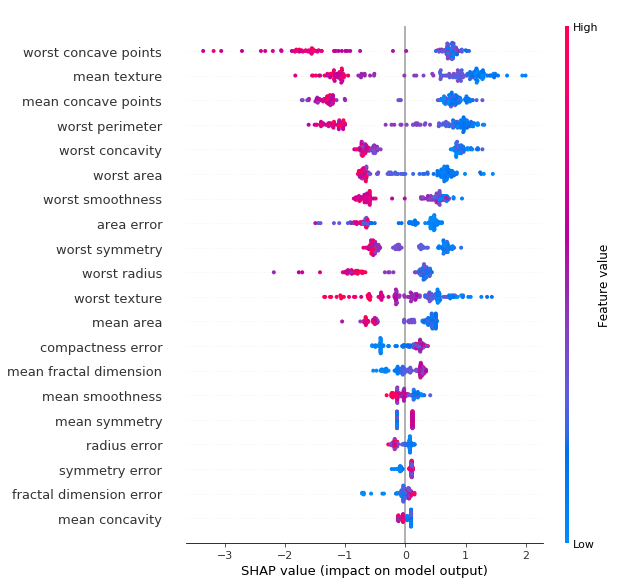

In [22]:
shap.summary_plot(shap_values, features = X_test)

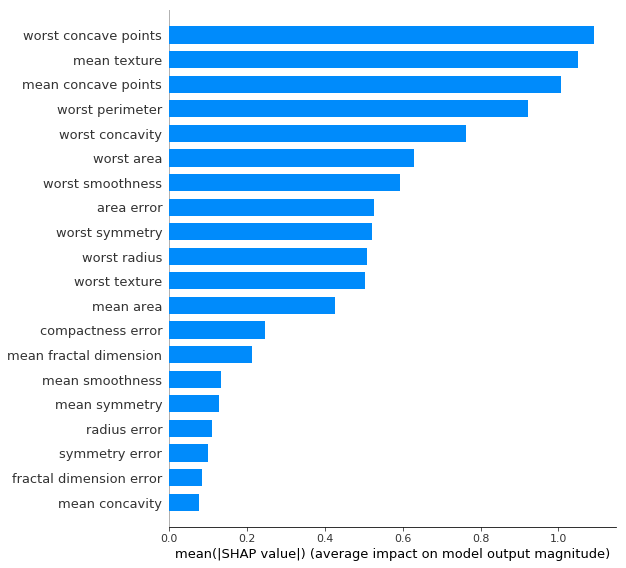

In [23]:
shap.summary_plot(shap_values, features = X_test, 
                  plot_type = 'bar')

In [24]:
X_test.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

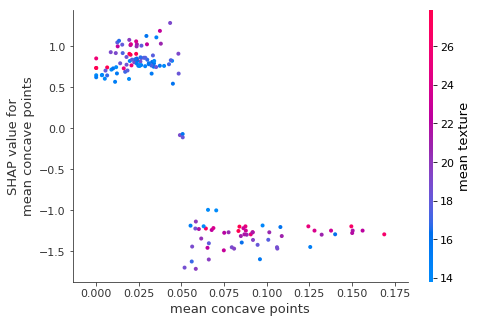

In [25]:
shap.dependence_plot(7, shap_values, features = X_test)

## Shap interaction values

In [29]:
from xgboost import XGBRegressor
import xgboost

In [30]:
X, y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

In [31]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [32]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
xgb_reg = XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.002, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00200000009, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='survival:cox', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(xgb_reg.predict(X_test, ntree_limit=5000), y_test)


0.8156233530479593

In [35]:
interaction_shap_values = shap.TreeExplainer(xgb_reg, link="logit").shap_interaction_values(X_test)


In [36]:
shap_values = shap.TreeExplainer(xgb_reg).shap_values(X_test)

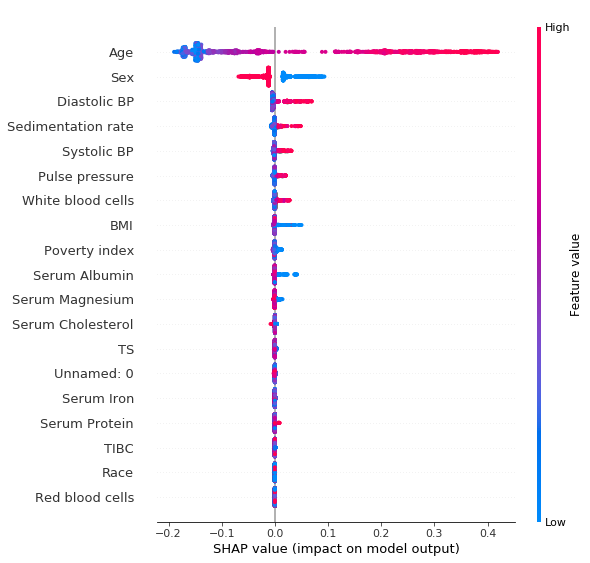

In [37]:
shap.summary_plot(shap_values, X_test)


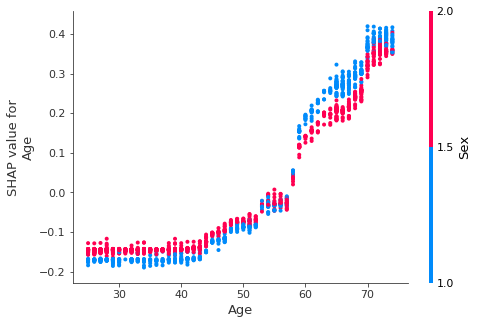

In [38]:
shap.dependence_plot("Age", shap_values, X_test)

In [45]:
shap_interaction_values = shap.TreeExplainer(xgb_reg).shap_interaction_values(X.iloc[:2000,:])


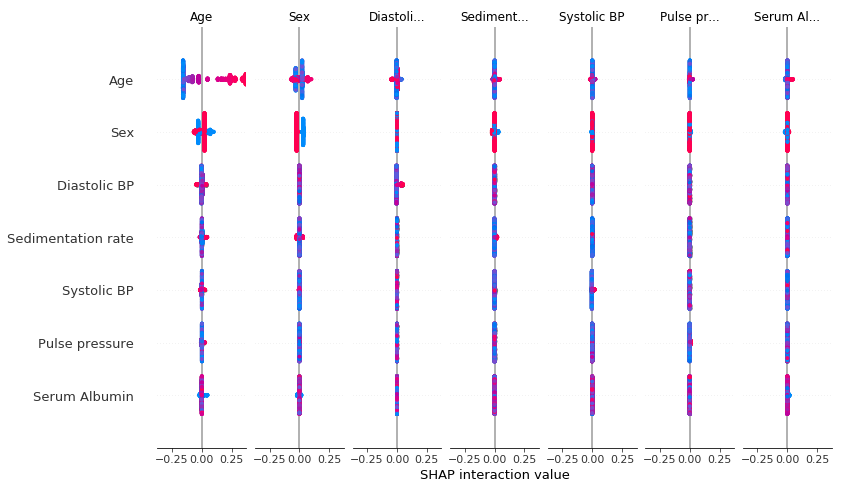

In [46]:
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])


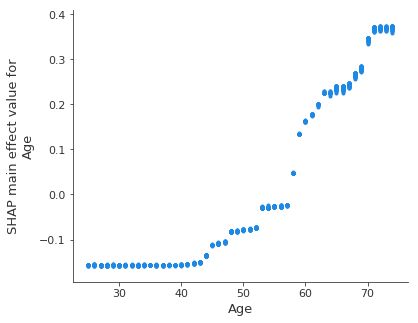

In [47]:
shap.dependence_plot(
    ("Age", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

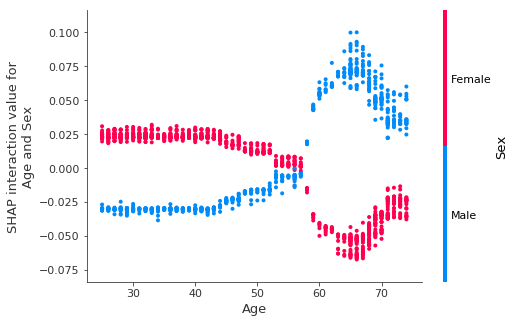

In [48]:
shap.dependence_plot(
    ("Age", "Sex"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

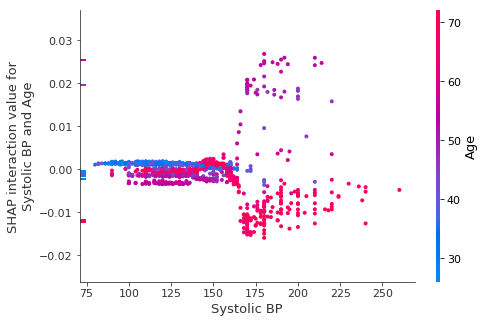

In [49]:
shap.dependence_plot(
    ("Systolic BP", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

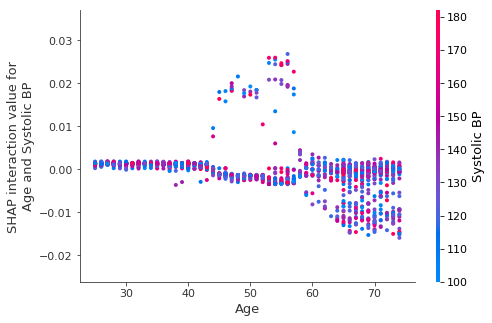

In [50]:
shap.dependence_plot(
    ("Age", "Systolic BP"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)